# Out-of-scope Prediction with GAN-BERT

In this notebook, we use the OOS+ variant of the CLINC150 dataset which contains 250 training utterances of the OOS class. 
We use the GAN-BERT model for the prediction of this oos class (label 42 in the huggingface dataset we use) and see how its performance compares to BERT-base, which the CLINC150 paper had tested on.

## Importing necessary packages

In [1]:
!pip install transformers==4.3.2
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 14.7 MB/s 
     |████████████████████████████████| 880 kB 69.6 MB/s 
     |████████████████████████████████| 3.3 MB 61.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=d8e4d97f1544a9bedbc8d7051b0bb34b5707a97b4562e5c66268105e063912a7
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 15.2 MB/s 
     |████████████████████████████████| 132 kB 71.0 MB/s 
     |████████████████████████████████| 182 kB 9.9 MB/s 
     |████████████████████████████████| 212 kB 67.9 MB/s 
     |████████████████████████████████| 127 kB 74.2 MB/s 
  Attempting uninstall: urllib3
    Found 

In [2]:
import json
from sklearn.model_selection import train_test_split
import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
import pandas as pd

from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from datasets import load_dataset

## Utility functions

In [3]:
# Set random values
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## Data Processing 

We are using the huggingface dataset for this exercise of seeing how well GAN-BERT performs in identifying out-of-scope examples.

For the previous exercise of in-scope prediction using different variations of labeled and unlabeled data, we used the 'FULL' variant of the CLINC150 as obtained from their repository. 
However, for this exercise, we have decided to load the 'OOS+' variant from huggingface for 2 reasons:
1. The OOS+ variant has more number of OOS examples as compared to the FULL dataset. The former contains 250 training examples whereas the latter contains only 100 training examples. 
2. The CLINC150 paper shows that the performance of BERT-base for out-of-scope prediction is the highest for the OOS+ dataset (as expected), hence we wanted to compare the performance of GAN-BERT with this best model. 


In [60]:
intent_dataset = load_dataset("clinc_oos","plus")

  0%|          | 0/3 [00:00<?, ?it/s]

In [61]:
# checking an oos example & how many oos are present
oos_texts = [sent for sent in intent_dataset['train'] if sent['intent']==42]
print(oos_texts[14])
print(len(oos_texts))

{'text': 'how many planets have we discovered', 'intent': 42}
250


#### Tokenization

Using the BertTokenizer for tokenization, BertModel as the pre-trained model and BertConfig for the parameters.

In [62]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True) 

In [63]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [64]:
max_length = 40

def tokenize_datasets(data):
  tokenized_datasets = {}
  for collection in data: 
    tokenized_datasets[collection] = tokenizer(data[collection]['text'], padding='max_length', max_length = max_length, truncation=True, return_tensors='pt')
    tokenized_datasets[collection]['intent'] = data[collection]['intent']

    tokenized_datasets[collection]['tokens'] = [["[CLS]"] + tokenizer.tokenize(row) + ["[SEP]"] for row in data[collection]['text']]
  
  return tokenized_datasets

We tokenize the dataset by converting the sentences to tokens as well as input ids. And special tokens of [CLS] and [SEP] are appending to the beginning and end of the sequence as needed by BERT. 

In [65]:
tokenized_datasets = tokenize_datasets(intent_dataset)

In [66]:
print("Tokens:", tokenized_datasets['train']['tokens'][0])
print(len(tokenized_datasets['train']['tokens'][0]))
print("Input Ids:", tokenized_datasets['train']['input_ids'][0])
print(tokenized_datasets['train']['input_ids'][0].size())
print("Attention Mask:", tokenized_datasets['train']['attention_mask'][0])
print("Intent:", tokenized_datasets['train']['intent'][0])

Tokens: ['[CLS]', 'what', 'expression', 'would', 'i', 'use', 'to', 'say', 'i', 'love', 'you', 'if', 'i', 'were', 'an', 'italian', '[SEP]']
17
Input Ids: tensor([ 101, 2054, 3670, 2052, 1045, 2224, 2000, 2360, 1045, 2293, 2017, 2065,
        1045, 2020, 2019, 3059,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
torch.Size([40])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Intent: 61


In [67]:
tokenized_datasets['train'].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'intent', 'tokens'])

In [68]:
# find the max sentence length for padding
max_len = 0
for idx, sent in enumerate(tokenized_datasets['train']['tokens']):
  if len(sent) > max_len:
    max_len = len(sent)
    max_sent_idx = idx

print(max_len)
print(max_sent_idx)
print(tokenized_datasets['train']['tokens'][max_sent_idx])

33
4569
['[CLS]', 'my', 'car', "'", 's', 'been', 'throwing', 'ce', '##ls', 'that', 'i', 'think', 'are', 'oil', 'related', ',', 'so', 'i', "'", 'm', 'wondering', 'if', 'it', "'", 's', 'time', 'to', 'take', 'it', 'in', 'or', 'not', '[SEP]']


We look at all the sentences from the train dataset to see which is the longest sentence. This helps us perform padding for all sentences in the batch. 
Looking at the above cell, we see that the max length of a sentence is 33 hence, to round it up, 40 has been taken as the max padded length for each sequence. 

#### Create Dataset & Dataloader

Since we do not have any unlabeled examples here that need to be masked in the model during inference (as done in the previous experiments), all the labels have a mask of 'True'. 

In [69]:
label_masks_train = np.ones(len(intent_dataset['train']), dtype=bool)
label_masks_val = np.ones(len(intent_dataset['validation']), dtype=bool)
label_masks_test = np.ones(len(intent_dataset['test']), dtype=bool)

In [70]:
#train dataloader
data = TensorDataset(tokenized_datasets['train']['input_ids'], tokenized_datasets['train']['attention_mask'], 
                      torch.tensor(tokenized_datasets['train']['intent']), torch.tensor(label_masks_train))

sampler = RandomSampler(data)

train_dataloader = DataLoader(data, sampler = sampler, batch_size = 64)

In [71]:
#val dataloader
data = TensorDataset(tokenized_datasets['validation']['input_ids'], tokenized_datasets['validation']['attention_mask'], 
                      torch.tensor(tokenized_datasets['validation']['intent']), torch.tensor(label_masks_val))

sampler = SequentialSampler(data)

val_dataloader = DataLoader(data, sampler = sampler, batch_size = 64)

In [72]:
#test dataloader
data = TensorDataset(tokenized_datasets['test']['input_ids'], tokenized_datasets['test']['attention_mask'], 
                      torch.tensor(tokenized_datasets['test']['intent']), torch.tensor(label_masks_test))

sampler = SequentialSampler(data)

test_dataloader = DataLoader(data, sampler = sampler, batch_size = 64)

Each batch in the dataloader have the following components:
1. Input Ids - converting tokens to numbers
2. Attention Masks - assigning a mask of 1 for [CLS], [SEP] and tokens, and 0 for all [PAD] tokens.
3. Label - intent as a number 
4. Label Mask - mask of 0 for unlabeled data and 1 for labeled data. 

## Building the Model

In [73]:
# BERT
transformer =  BertModel.from_pretrained("bert-base-uncased")

In [74]:
#Generator

class Generator(nn.Module):
    def __init__(self, noise_size, output_size, hidden_sizes, dropout_rate):
        super(Generator, self).__init__()
        layers = []
        hidden_sizes = [noise_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        layers.append(nn.Linear(hidden_sizes[-1],output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        output_rep = self.layers(noise)
        return output_rep

In [75]:
# Discriminator

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_labels, dropout_rate):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

In [76]:
noise_size = 100
config = BertConfig.from_pretrained("bert-base-uncased")
hidden_size = config.hidden_size # BERT outputs a 768 embedding vector
num_hidden_layers_gen = 1
hidden_levels_gen = [hidden_size for i in range(0, num_hidden_layers_gen)]
num_hidden_layers_disc = 1
hidden_levels_disc = [hidden_size for i in range(0, num_hidden_layers_disc)]

# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

intents = [sent['intent'] for sent in intent_dataset['train']]
num_labels = len(set(intents))

generator = Generator(noise_size=noise_size, #100
                      output_size=hidden_size, #768
                      hidden_sizes=hidden_levels_gen, #[768] 
                      dropout_rate=out_dropout_rate) #0.2

discriminator = Discriminator(input_size=hidden_size, #768
                              hidden_sizes=hidden_levels_disc, #[768]
                              num_labels=num_labels, #150 + 1oos
                              dropout_rate=out_dropout_rate) #0.2


In [77]:
# input dim - 100x768
# output dim - 768x768
generator

Generator(
  (layers): Sequential(
    (0): Linear(in_features=100, out_features=768, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=768, out_features=768, bias=True)
  )
)

In [78]:
# input dim - 768x768
# output dim - 768x152
discriminator  

Discriminator(
  (input_dropout): Dropout(p=0.2, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
  )
  (logit): Linear(in_features=768, out_features=152, bias=True)
  (softmax): Softmax(dim=-1)
)

In [ ]:
# input dim - 30522x768
# output dim - 768x768
transformer 

In [80]:
multi_gpu = True
if torch.cuda.is_available():    
  generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

In [81]:
#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = transformer_vars + [v for v in discriminator.parameters()]
g_vars = [v for v in generator.parameters()]

learning_rate_generator = 5e-5
learning_rate_discriminator = 5e-5

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator) 

In [82]:
#scheduler
apply_scheduler = False
batch_size = 64
num_epochs = 10
warmup_proportion = 0.1

if apply_scheduler:
  num_train_examples = len(intent_dataset['train'])
  num_train_steps = int(num_train_examples / batch_size * num_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
  scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                           num_warmup_steps = num_warmup_steps)

## Training & Evaluation

In [83]:
training_stats = []
train_gen_loss_history = []
train_disc_loss_history = []
val_loss_history = []
val_accuracies = []
predictions = []
gold_labels = []

for epoch in range(num_epochs):
  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch + 1, num_epochs))
  print('Training...')

  t0 = time.time()

  # loss for each epoch
  tr_g_loss = 0
  tr_d_loss = 0

  transformer.train()
  generator.train()
  discriminator.train()

  # for idx, batch in enumerate(data_loaders['train']):
  for idx, batch in enumerate(train_dataloader):

    # Progress update every print_each_n_step batches.
    if idx % 40 == 0 and not idx == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(idx, len(train_dataloader), elapsed))

    b_input_ids = batch[0].to(device) #tensor of input ids of that batch
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    b_label_mask = batch[3].to(device)

    real_batch_size = b_input_ids.shape[0] 
    # print('real_batch_size: ', real_batch_size) #size of each batch = 32

    model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
    hidden_states = model_outputs[-1]
    # print('hidden states', hidden_states.size()) #32x768 - 768 per sentence in batch

    noise = torch.zeros(real_batch_size, noise_size, device=device).uniform_(0, 1)
    # print('noise', noise.size()) # 32x100 - 100 per sentence in batch 
    gen_rep = generator(noise)
    # print('gen output', gen_rep.size()) #32x768 
    # both transformer + gen output are 768 size

    disciminator_input = torch.cat([hidden_states, gen_rep], dim=0)
    # print('disc input', disciminator_input.size()) # 64x768
    features, logits, probs = discriminator(disciminator_input)

    features_list = torch.split(features, real_batch_size) #split 64x768 into 32,32
    D_real_features = features_list[0]
    D_fake_features = features_list[1] 

    logits_list = torch.split(logits, real_batch_size)
    D_real_logits = logits_list[0]
    D_fake_logits = logits_list[1]  

    probs_list = torch.split(probs, real_batch_size)
    D_real_probs = probs_list[0]
    D_fake_probs = probs_list[1]

    #loss

    #gen loss
    g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + 1e-8))
    g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
    g_loss = g_loss_d + g_feat_reg

    #disc loss
    logits = D_real_logits[:,0:-1]
    log_probs = F.log_softmax(logits, dim=-1)

    label2one_hot = torch.nn.functional.one_hot(b_labels, 151)
    per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
    per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
    labeled_example_count = per_example_loss.type(torch.float32).numel()

    if labeled_example_count == 0:
      D_L_Supervised = 0
    else:
      D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)

    D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + 1e-8))
    D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + 1e-8))
    d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

    #optimization
    gen_optimizer.zero_grad()
    dis_optimizer.zero_grad()

    g_loss.backward(retain_graph=True)
    d_loss.backward()

    gen_optimizer.step()
    dis_optimizer.step()

    tr_g_loss += g_loss.item()
    tr_d_loss += d_loss.item()

    if apply_scheduler:
      scheduler_d.step()
      scheduler_g.step()

  avg_train_loss_g = tr_g_loss / len(train_dataloader)
  avg_train_loss_d = tr_d_loss / len(train_dataloader)
  
  training_time = format_time(time.time() - t0)

  print("")
  print("  Average training loss generator: {0:.3f}".format(avg_train_loss_g))
  print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
  print("  Training epoch took: {:}".format(training_time))
  train_gen_loss_history.append(avg_train_loss_g)
  train_disc_loss_history.append(avg_train_loss_d)

  #EVALUATION

  print("")
  print("Running validation...")

  t0 = time.time()

  transformer.eval() 
  discriminator.eval()
  generator.eval()

  total_test_accuracy = 0
   
  total_test_loss = 0
  nb_test_steps = 0

  all_preds = []
  all_labels_ids = []

  #loss
  nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

  # for batch in data_loaders['validation']:
  for idx, batch in enumerate(val_dataloader):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():        
        model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        hidden_states = model_outputs[-1]
        _, logits, probs = discriminator(hidden_states)
        ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
        filtered_logits = logits[:,0:-1]
        # Accumulate the test loss.
        total_test_loss += nll_loss(filtered_logits, b_labels)

    # Accumulate the predictions and the input labels
    _, preds = torch.max(filtered_logits, 1)
    all_preds += preds.detach().cpu()
    all_labels_ids += b_labels.detach().cpu()


  # Report the final accuracy for this validation run.
  all_preds = torch.stack(all_preds).numpy()
  all_labels_ids = torch.stack(all_labels_ids).numpy()

  predictions.extend(all_preds)
  gold_labels.extend(all_labels_ids)

  test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
  print("  Accuracy: {0:.3f}".format(test_accuracy))
  val_accuracies.append(test_accuracy)

  # Calculate the average loss over all of the batches.
  avg_test_loss = total_test_loss / len(val_dataloader)
  avg_test_loss = avg_test_loss.item()

  test_time = format_time(time.time() - t0)
    
  print("  Test Loss: {0:.3f}".format(avg_test_loss))
  print("  Test took: {:}".format(test_time))
  val_loss_history.append(avg_test_loss)

  training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )




======== Epoch 1 / 10 ========
Training...
  Batch    40  of    239.    Elapsed: 0:00:23.
  Batch    80  of    239.    Elapsed: 0:00:47.
  Batch   120  of    239.    Elapsed: 0:01:11.
  Batch   160  of    239.    Elapsed: 0:01:36.
  Batch   200  of    239.    Elapsed: 0:02:00.

  Average training loss generator: 0.679
  Average training loss discriminator: 5.190
  Training epoch took: 0:02:24

Running validation...
  Accuracy: 0.619
  Test Loss: 2.627
  Test took: 0:00:06

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    239.    Elapsed: 0:00:25.
  Batch    80  of    239.    Elapsed: 0:00:49.
  Batch   120  of    239.    Elapsed: 0:01:14.
  Batch   160  of    239.    Elapsed: 0:01:38.
  Batch   200  of    239.    Elapsed: 0:02:03.

  Average training loss generator: 0.778
  Average training loss discriminator: 2.410
  Training epoch took: 0:02:26

Running validation...
  Accuracy: 0.882
  Test Loss: 0.939
  Test took: 0:00:06

======== Epoch 3 / 10 ========
Training...


## Testing

In [84]:
print("")
print("Running test...")

t0 = time.time()

transformer.eval() 
discriminator.eval()
generator.eval()

total_test_accuracy = 0
  
total_test_loss = 0
nb_test_steps = 0

all_preds = []
all_labels_ids = []

#loss
nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

# for batch in data_loaders['validation']:
for idx, batch in enumerate(test_dataloader):
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)

  with torch.no_grad():        
      model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
      hidden_states = model_outputs[-1]
      _, logits, probs = discriminator(hidden_states)
      ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
      filtered_logits = logits[:,0:-1]
      # Accumulate the test loss.
      total_test_loss += nll_loss(filtered_logits, b_labels)

  # Accumulate the predictions and the input labels
  _, preds = torch.max(filtered_logits, 1)
  all_preds += preds.detach().cpu()
  all_labels_ids += b_labels.detach().cpu()


# Report the final accuracy for this validation run.
all_preds = torch.stack(all_preds).numpy()
all_labels_ids = torch.stack(all_labels_ids).numpy()
test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
print("  Accuracy: {0:.3f}".format(test_accuracy))

# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss / len(test_dataloader)
avg_test_loss = avg_test_loss.item()

test_time = format_time(time.time() - t0)
  
print("  Test Loss: {0:.3f}".format(avg_test_loss))
print("  Test took: {:}".format(test_time))


Running test...
  Accuracy: 0.875
  Test Loss: 0.618
  Test took: 0:00:10


## Results

In [85]:
# checking precision, recall, f1 scores
from sklearn.metrics import classification_report
print(classification_report(gold_labels, predictions))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       200
           1       0.78      0.76      0.77       200
           2       0.93      0.83      0.88       200
           3       0.95      0.96      0.96       200
           4       0.91      0.94      0.93       200
           5       0.93      0.96      0.94       200
           6       0.97      0.82      0.89       200
           7       0.95      0.98      0.97       200
           8       0.90      0.94      0.92       200
           9       0.72      0.94      0.82       200
          10       0.90      0.90      0.90       200
          11       0.86      0.80      0.83       200
          12       0.90      0.96      0.93       200
          13       0.97      0.83      0.89       200
          14       0.87      1.00      0.93       200
          15       0.95      0.94      0.95       200
          16       0.97      0.76      0.85       200
          17       0.93    

Focusing on the out-of-scope label 

Label: 42       
Precision: 0.86      
Recall:0.65      
F1-score:0.74      
Support: 1000

We use recall to evaluate out-of-scope since we are more interested in cases where such queries are predicted as in-scope, as this would mean a system gives the user a response that is completely wrong. Precision errors are less problematic as the fallback response will prompt the user to try again, or inform the user of the system’s scope of supported domains.

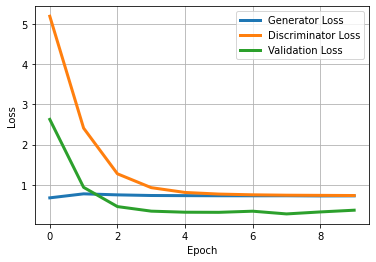

In [86]:
#loss curves
import matplotlib.pyplot as plt
plt.plot(range(10),train_gen_loss_history,'-',linewidth=3,label='Generator Loss')
plt.plot(range(10),train_disc_loss_history,'-',linewidth=3,label='Discriminator Loss')
plt.plot(range(10),val_loss_history,'-',linewidth=3,label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

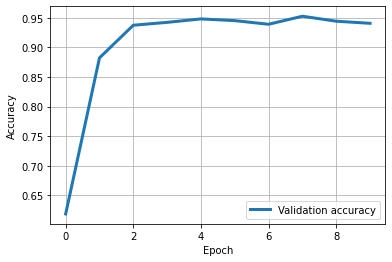

In [87]:
#accuracy curves
plt.plot(range(10), val_accuracies,'-', linewidth=3, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

The model has a decreasing loss curve for the generator loss, discriminator loss as well as the validation loss.
And a stable increasing accuracy curve for validation accuracy - converging at around 95% accuracy which is similar to the BERT-base model.